In [130]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from cvxopt import matrix, solvers
from scipy.optimize import minimize

In [131]:
# Read data into pandas
japan = pd.read_excel("./data/Price History_EWJ_Japan_Equity.xlsx")
t_bills_7_10 = pd.read_excel("./data/Price History_7-10_US_TBills.xlsx")
t_bills_20 = pd.read_excel("./data/Price History_20+_US_TBills.xlsx")
apac_x_japan = pd.read_excel("./data/Price History_EPP_APACxJapan_Equity.xlsx")
europe = pd.read_excel("./data/Price History_IEV_Europe_Equity.xlsx")
latam = pd.read_excel("./data/Price History_ILF_LatAm_Equity.xlsx")
us = pd.read_excel("./data/Price History_IVV_US_Equity.xlsx")
gold = pd.read_excel("./data/Price History_IAU_Gold_Trust.xlsx")

In [132]:
def preprocess_and_rename(df, name):
    df['Exchange Date'] = pd.to_datetime(df['Exchange Date'])
    df.set_index('Exchange Date', inplace=True)
    df.rename(columns={'%Chg':f'Return {name}'}, inplace=True)
    return df[[f'Return {name}']]

# Preprocess all datasets and rename columns
japan = preprocess_and_rename(japan, 'Japan')
t_bills_7_10 = preprocess_and_rename(t_bills_7_10, 'T-Bills_7_10')
t_bills_20 = preprocess_and_rename(t_bills_20, 'T-Bills_20')
apac_x_japan = preprocess_and_rename(apac_x_japan, 'APACxJapan')
europe = preprocess_and_rename(europe, 'Europe')
latam = preprocess_and_rename(latam, 'LatAm')
us = preprocess_and_rename(us, 'US')
gold = preprocess_and_rename(gold, 'Gold')

In [133]:
us

,Return US
Exchange Date,
2024-12-13,-0.000181
2024-12-12,-0.005306
2024-12-11,0.007707
2024-12-10,-0.002896
2024-12-09,-0.005157
...,...
2005-01-07,-0.001852
2005-01-06,0.004058
2005-01-05,-0.006050


In [134]:
# Merge all datasets on 'Exchange Date'
returns = japan.join([t_bills_7_10, t_bills_20, apac_x_japan, europe, latam, us, gold], how='inner')

# Rename the columns for clarity
returns.columns = ['Japan', 'T-Bills_7_10', 'T-Bills_20', 
                'APACxJapan','Europe','LatAm', 'US', 'Gold']
returns = returns.dropna()
returns = returns.sort_values(by='Exchange Date', ascending=True)

In [135]:
returns

,Japan,T-Bills_7_10,T-Bills_20,APACxJapan,Europe,LatAm,US,Gold
Exchange Date,,,,,,,,
2005-01-31,0.000000,0.000350,0.002843,0.002793,0.004750,0.017648,0.008956,-0.009838
2005-02-01,0.005666,-0.003734,-0.005343,0.008802,0.010265,0.013544,0.006425,-0.003549
2005-02-02,0.003756,0.000117,0.002302,0.000884,-0.000668,0.009117,0.003192,0.002612
2005-02-03,-0.014967,-0.001757,-0.000875,-0.008056,-0.002676,0.010767,-0.001758,-0.012077
2005-02-04,0.004748,0.005280,0.014231,0.007231,0.003622,0.017877,0.009646,-0.005273
...,...,...,...,...,...,...,...,...
2024-12-09,-0.008723,-0.003464,-0.009217,0.018423,-0.001273,0.012993,-0.005157,0.009863
2024-12-10,-0.005393,-0.001791,-0.004705,-0.016197,-0.008379,0.000855,-0.002896,0.013155
2024-12-11,0.014127,-0.002955,-0.009454,0.000000,0.004041,0.015805,0.007707,0.009247


Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.13371408696416
            Iterations: 11
            Function evaluations: 104
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.0814382546681003
            Iterations: 12
            Function evaluations: 112
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.8700922661538857
            Iterations: 13
            Function evaluations: 125
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.4774008506472114
            Iterations: 11
            Function evaluations: 100
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.6502060977402908
            Iterations: 10
            Funct

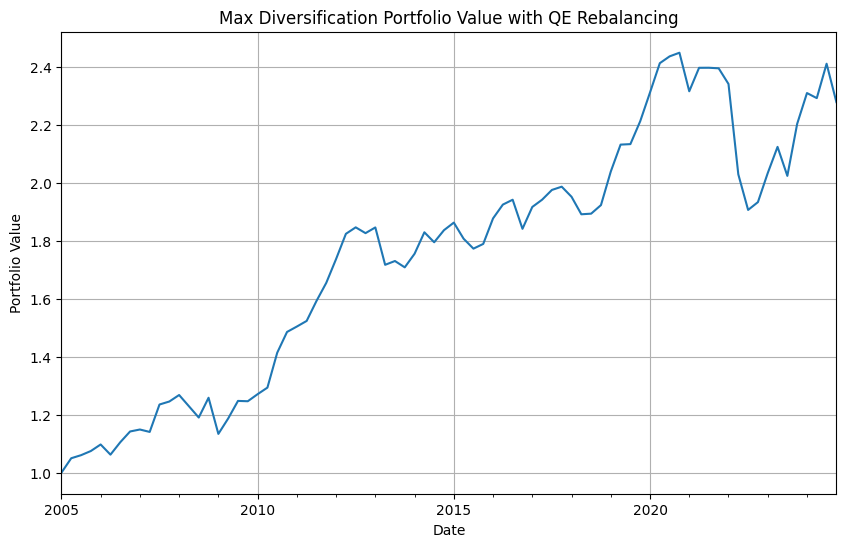

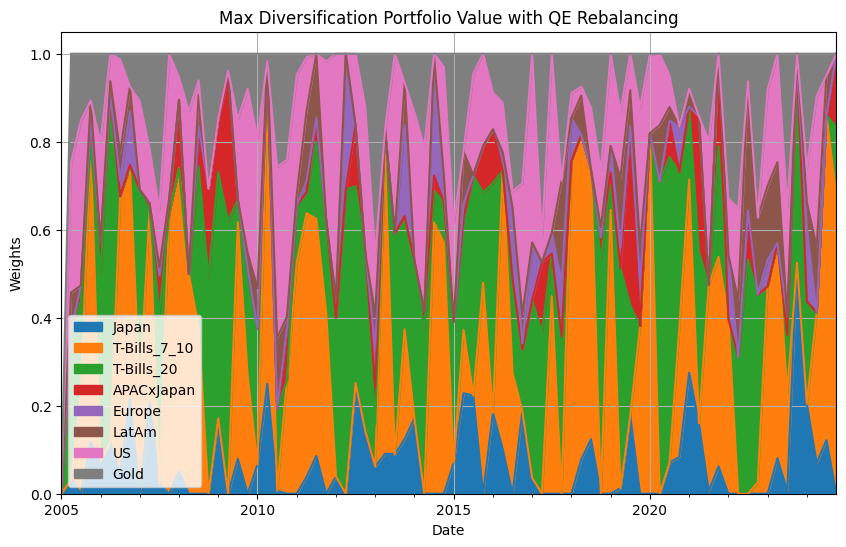

In [136]:

# Helper to calculate portfolio diversification
def calc_diversification_ratio(w, V):
    # Weighted volatility
    w_vol = np.dot(np.sqrt(np.diag(V)), w.T)
    # Portfolio volatility
    port_vol = np.sqrt(np.dot(w.T, np.dot(V, w)))
    # Diversification ratio (maximize)
    diversification_ratio = w_vol / port_vol
    # Return negative for minimization problem
    return -diversification_ratio

# Helper for weight constraint
def total_weight_constraint(w):
    return np.sum(w) - 1  # Total weights sum to 1

# Function to calculate the cumulative return for each asset in the month
def calculate_cumulative_return(asset_returns):
    return (asset_returns + 1).prod() - 1

#Portfolio optimization function to maximize diversification
def max_diversification_optimizer(w0, V, bnd = [(0, 1) for _ in range(len(returns.columns))], long_only=True):
    cons = ({'type': 'eq', 'fun': total_weight_constraint},)
    if long_only:  # add long only constraint
        cons = cons + ({'type': 'ineq', 'fun': lambda w: w},)

         # Add tolerance options for SLSQP
    options = {'maxiter': 1000, 'ftol': 1e-10, 'disp': True}  # Change these as needed

    res = minimize(calc_diversification_ratio, w0, bounds=bnd, args=(V,), method='SLSQP', constraints=cons, options=options)

    return res

# Main function to calculate maximum diversification portfolio over time
def max_diversification_portfolio(returns, rebalance_frequency, initial_investment=1):
    # Resample returns based on rebalancing frequency (monthly, quarterly, etc.)
    resampled_returns = returns.resample(rebalance_frequency).apply(lambda x: (x + 1).prod() - 1)
    # Initialize portfolio value
    portfolio_value = pd.Series(index=resampled_returns.index, data=np.nan)
    portfolio_weights = pd.DataFrame(index=resampled_returns.index, columns=returns.columns, data=np.nan)
    portfolio_value.iloc[0] = initial_investment  # Initial investment on the first day

    # Define initial weight (equal weight for simplicity)
    w0 = np.ones(returns.shape[1]) / returns.shape[1]

    # Loop through the resampled returns to rebalance
    for i in range(1, len(resampled_returns)):
        #1 Determine the actual rebalancing window (last quarter of daily returns)
        rebal_start = resampled_returns.index[i-1]
        rebal_end = resampled_returns.index[i]

        #2 Specify timeframe for covariance calculation starting from REBAL_END
        lookback_days = 252/12
        cov_start = rebal_end - pd.DateOffset(days=lookback_days)
        cov_data = returns.loc[cov_start : rebal_end]

        # Skip if there is not enough data (e.g., Na's)
        if cov_data.isna().any().any() or len(cov_data) < 2:
            print(f"Skipping period {resampled_returns.index[i]} due to insufficient data.")
            continue

        #3 Calculate covariance matrix for the daily returns of the #2 specified period
        V = np.cov(cov_data.T)
        #4 Optimize portfolio weights based on minimum variance
        res = max_diversification_optimizer(w0, V)
        if not res.success:
            print(f"Optimization failed at {resampled_returns.index[i]}")
            continue

        optimal_weights = res.x
        assert all(0 <= w <= 1 for w in optimal_weights), "Weights are not within the bounds."
        portfolio_weights.iloc[i] = optimal_weights

        #5 Calculate actual portfolio return for just the last period
        current_period = returns.loc[rebal_start:rebal_end]
        cumulative_returns = current_period.apply(lambda x: (x + 1).prod() - 1, axis=0)
        portfolio_return = np.dot(optimal_weights, cumulative_returns)

        #6 Update portfolio value (assuming no transaction costs)
        portfolio_value.iloc[i] = portfolio_value.iloc[i-1] * (1 + portfolio_return)

        w0 = optimal_weights

    return portfolio_value, portfolio_weights

#### Actual Function Call ####

rebalance_frequency = 'QE'  # ME = monthly, QE = quarterly, YE = yearly
portfolio_value, portfolio_weights = max_diversification_portfolio(returns, rebalance_frequency)

# Plot the portfolio value over time
portfolio_value.plot(figsize=(10, 6))
plt.title(f'Max Diversification Portfolio Value with {rebalance_frequency} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()

"""asset_groups = {
    'Equity': ['Japan', 'APACxJapan', 'Europe', 'LatAm', 'US'],  # Equity
    'Bonds': ['T-Bills_7_10', 'T-Bills_20'],  # Bonds,
    'Gold': ['Gold'] # Gold
}
def group_weights(weights, asset_groups):
    grouped_weights = pd.DataFrame(index=weights.index)

    # For each group, sum up the weights of the assets in that group
    for group, assets in asset_groups.items():
        grouped_weights[group] = weights[assets].sum(axis=1)

    return grouped_weights"""

#group_weights(portfolio_weights, asset_groups).plot(kind='area', stacked=True, figsize=(14, 8))
portfolio_weights.plot(kind='area', stacked=True, figsize=(10, 6))
plt.title(f'Max Diversification Portfolio Value with {rebalance_frequency} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Weights')
plt.grid(True)
plt.show()

In [137]:
# Calculate monthly returns from the portfolio value
portfolio_returns = portfolio_value.pct_change().dropna()  # Monthly returns

# Calculate the monthly volatility (standard deviation of returns)
monthly_volatility = portfolio_returns.std()

# Annualize the volatility (multiply by sqrt(12))
annualized_volatility = monthly_volatility * np.sqrt(12)

# Calculate average annualized monthly volatility
rolling_annual_volatility = portfolio_returns.rolling(window=21).std() * np.sqrt(12)  # 21 trading days in a month
print(f"Average annualized monthly volatility: {rolling_annual_volatility.mean()}")

# Calculate total return (from the initial to the final value)
total_return = (portfolio_value.iloc[-1] - portfolio_value.iloc[0]) / portfolio_value.iloc[0]
print(f"Total return: {total_return * 100:.2f}%")

# Calculate average monthly return
avg_monthly_return = portfolio_returns.mean()
print(f"Average monthly return: {avg_monthly_return * 100:.2f}%")

# Calculate average yearly return (annualized return)
avg_yearly_return = ((1 + avg_monthly_return) ** 12) - 1
print(f"Average yearly return: {avg_yearly_return * 100:.2f}%")

# Calculate the Sharpe ratio (assuming risk-free rate is 0)
sharpe_ratio = avg_yearly_return / rolling_annual_volatility.mean()
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Calculate the monthly VaR for each month using the Historical Simulation method
VaR_99 = portfolio_returns.quantile(1 - 0.99)
print(f"Monthly 99% Value at Risk (VaR) is: {VaR_99:.4f}")

Average annualized monthly volatility: 0.12835018391326317
Total return: 127.86%
Average monthly return: 1.13%
Average yearly return: 14.41%
Sharpe Ratio: 1.12
Monthly 99% Value at Risk (VaR) is: -0.1066
